### Initial Data Set Up

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import ta
from ta import momentum
import ccxt
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from datetime import datetime, timedelta, timezone, date

%matplotlib inline

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Get data from Binance exchange
exchange_class = getattr(ccxt,'binance')
exchange = exchange_class({
    'apiKey': '',
    'secret': '',
    'timeout': 30000,
    'enableRateLimit': True,
})

In [2]:
# Data function to get data depending on timeframe
def get_symbol_history(symbol,timeframe,start_date,end_date):
    
    if time_frame == '15m':
        # 1000 x 15m = 10 days
        freq = '10D'
    elif time_frame == '1h':
        # 1000 hours = 41 days
        freq = '41D'
    elif time_frame == '4h':
        # 1000 x 4h = 3 years
        freq = '166D'
    elif time_frame == '1d':
        # 1000 x 1d = 3 years
        freq = '3Y'
    
    period_starts = list(pd.date_range(start=start_date, end=end_date,freq=freq,tz='UTC').astype(np.int64))
    
    df = pd.DataFrame()
    for month in period_starts:
        since = int(month/1000000)
        new_df = pd.DataFrame(exchange.fetch_ohlcv(symbol, time_frame,since=since,limit=1000))
        if len(new_df) > 0:
            df = df.append(new_df)
    if len(df)>0:
        header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
        df.columns = header
    
    df = df.drop_duplicates() 
    df.reset_index(drop=True) 

    df.index = pd.to_datetime(df['Timestamp'],unit='ms')
    df.drop(columns = ['Timestamp'],inplace=True)
    
    return df

In [3]:
# Set data date range, timeframe and trading pair/ symbol
start_date = '16/07/2018' #3Y 'long term model' example
end_date = '15/07/2021'
time_frame = '1d' 
symbol = 'BTC/USDT'

raw_df = get_symbol_history(symbol,time_frame,start_date,end_date)

In [4]:
btc_df = raw_df.copy()

In [5]:
btc_df.tail()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2021-07-12,34259.00,34678.43,32658.34,33086.63,48181.403762
2021-07-13,33086.94,33340.00,32202.25,32729.77,41126.361008
2021-07-14,32729.12,33114.03,31550.00,32820.02,46777.823484
2021-07-15,32820.03,33185.25,31133.00,31880.00,51639.576353
2021-07-16,31874.49,32049.45,31548.15,31661.52,13731.381501


In [6]:
# Drop NAs and calculate daily percent return
btc_df["hourly_return"] = btc_df["Close"].dropna().pct_change()
btc_df["target"] = btc_df["Close"].dropna().pct_change(7) #to capture change in last 24hrs or units of time (for short term 24hrs, long term 7 days)

# Display sample data
btc_df.head(25)

,Open,High,Low,Close,Volume,hourly_return,target
Timestamp,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,-0.005551,NaN
2019-01-06,3771.12,4027.71,3740.00,3987.60,36553.806709,0.057450,NaN
2019-01-07,3987.62,4017.90,3921.53,3975.45,31869.846264,-0.003047,0.073604
2019-01-08,3976.76,4069.80,3903.00,3955.13,38901.423122,-0.005111,0.041608


### Moving Averages Indicator

In [7]:
# Set short and long windows
short_window = 3
long_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_close"] = btc_df["Close"].ewm(halflife=short_window).mean()
btc_df["slow_close"] = btc_df["Close"].ewm(halflife=long_window).mean()

# Crossover trading indicator
btc_df["crossover_long"] = np.where(btc_df["fast_close"] > btc_df["slow_close"], 1.0, 0.0)
btc_df["crossover_short"] = np.where(btc_df["fast_close"] < btc_df["slow_close"], -1.0, 0.0)
btc_df["crossover_signal"] = btc_df["crossover_long"] + btc_df["crossover_short"]

btc_df.head(10)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Timestamp,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,0.0,1.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,0.0,1.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,0.0,1.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,0.0,1.0
2019-01-05,3790.09,3840.99,3751.00,3770.96,30490.667751,-0.005551,NaN,3783.840279,3782.546715,1.0,0.0,1.0
2019-01-06,3771.12,4027.71,3740.00,3987.60,36553.806709,0.057450,NaN,3836.281448,3818.266831,1.0,0.0,1.0
2019-01-07,3987.62,4017.90,3921.53,3975.45,31869.846264,-0.003047,0.073604,3870.358674,3842.996224,1.0,0.0,1.0
2019-01-08,3976.76,4069.80,3903.00,3955.13,38901.423122,-0.005111,0.041608,3890.345279,3859.176032,1.0,0.0,1.0


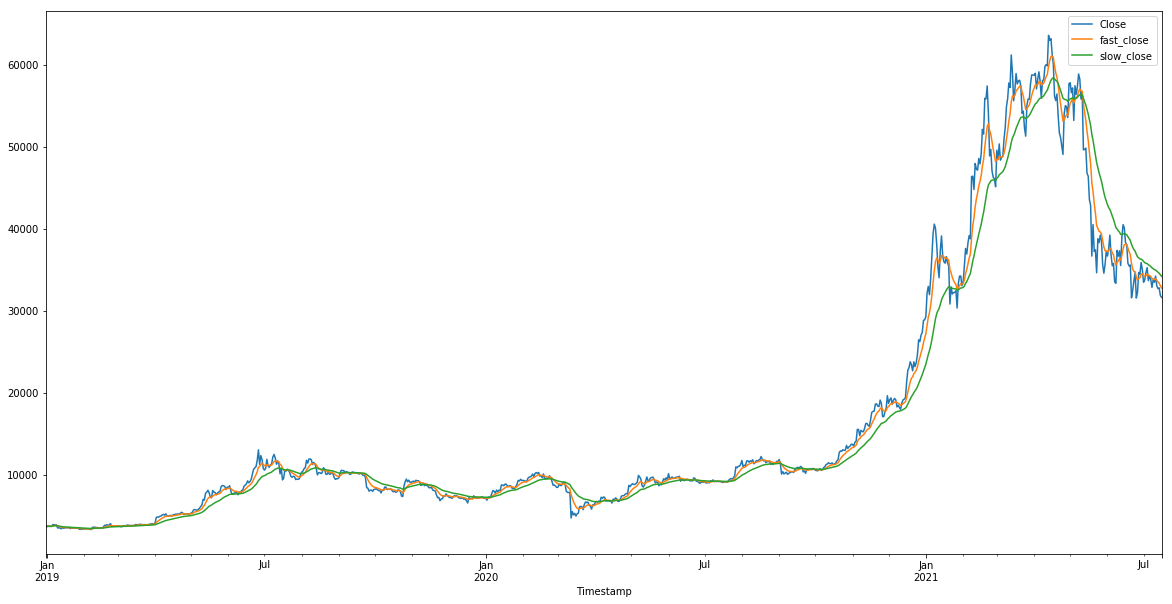

In [8]:
# Plot EMA of BTC/USD closing prices
btc_df[["Close", "fast_close", "slow_close"]].plot(figsize=(20,10))

### Volatility Indicator

In [9]:
# Set short and long volatility windows
short_vol_window = 3
long_vol_window = 10

# Set `Fast` and `Slow` Exponential Moving Average from short and long windows
btc_df["fast_vol"] = btc_df["hourly_return"].ewm(halflife=short_vol_window).std()
btc_df["slow_vol"] = btc_df["hourly_return"].ewm(halflife=long_vol_window).std()

# Crossover trading signal
btc_df["vol_trend_long"] = np.where(btc_df["fast_vol"] < btc_df["slow_vol"], 1.0, 0.0)
btc_df["vol_trend_short"] = np.where(btc_df["fast_vol"] > btc_df["slow_vol"], -1.0, 0.0) 
btc_df["vol_trend_signal"] = btc_df["vol_trend_long"] + btc_df["vol_trend_short"]

btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Timestamp,,,,,,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,0.0,1.0,0.006558,0.006558,0.0,-1.0,-1.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,0.0,1.0,0.027158,0.026487,0.0,-1.0,-1.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,0.0,1.0,0.020970,0.021267,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12,34259.00,34678.43,32658.34,33086.63,48181.403762,-0.034221,-0.017914,33749.900397,34869.821384,0.0,-1.0,-1.0,0.029411,0.040100,1.0,0.0,1.0
2021-07-13,33086.94,33340.00,32202.25,32729.77,41126.361008,-0.010786,-0.043549,33539.448032,34726.508545,0.0,-1.0,-1.0,0.026332,0.038788,1.0,0.0,1.0
2021-07-14,32729.12,33114.03,31550.00,32820.02,46777.823484,0.002757,-0.030775,33391.030408,34598.836710,0.0,-1.0,-1.0,0.023757,0.037498,1.0,0.0,1.0


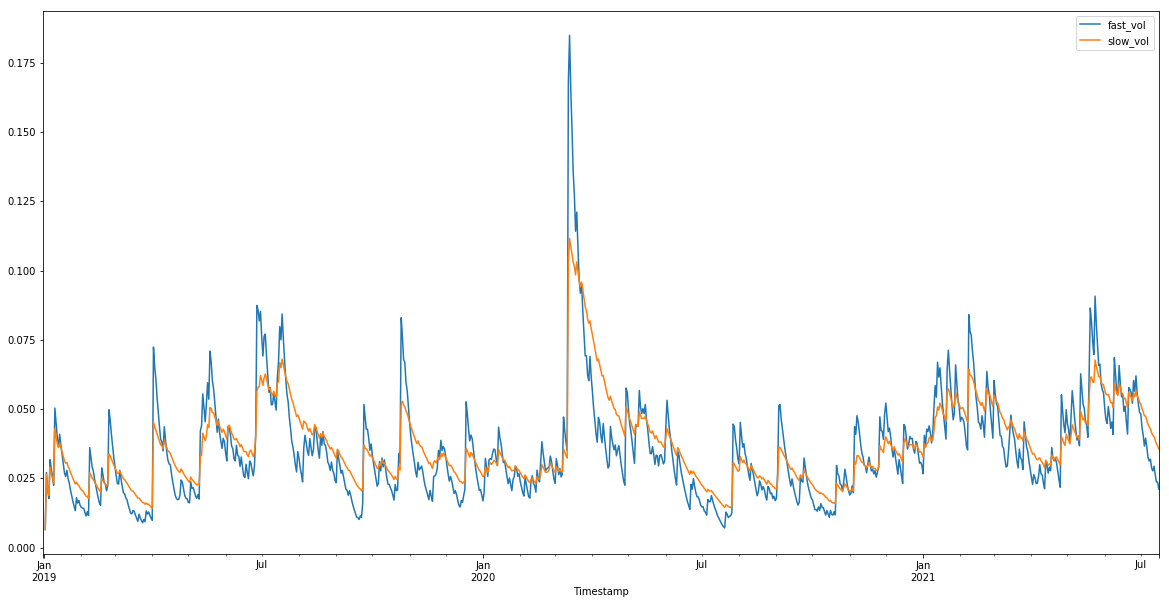

In [10]:
# Plot EMA of BTC/USD daily return volatility
btc_df[["fast_vol", "slow_vol"]].plot(figsize=(20,10))

### Bollinger Bands Indicator

In [11]:
# Set bollinger band window
bollinger_window = 20

# Rolling mean and standard deviation
btc_df["bollinger_mid_band"] = btc_df["Close"].rolling(window=bollinger_window).mean()
btc_df["bollinger_std"] = btc_df["Close"].rolling(window=20).std()

# Upper and lowers bands of bollinger band
btc_df["bollinger_upper_band"]  = btc_df["bollinger_mid_band"] + (btc_df["bollinger_std"] * 1)
btc_df["bollinger_lower_band"]  = btc_df["bollinger_mid_band"] - (btc_df["bollinger_std"] * 1)

# Bollinger band trading signal
btc_df["bollinger_long"] = np.where(btc_df["Close"] < btc_df["bollinger_lower_band"], 1.0, 0.0)
btc_df["bollinger_short"] = np.where(btc_df["Close"] > btc_df["bollinger_upper_band"], -1.0, 0.0)
btc_df["bollinger_signal"] = btc_df["bollinger_long"] + btc_df["bollinger_short"]

btc_df

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-12-31,3803.12,3810.00,3630.33,3702.90,29991.778350,NaN,NaN,3702.900000,3702.900000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.687033,0.025450,NaN,3755.439428,3751.652401,1.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-02,3796.45,3882.14,3750.45,3858.56,35156.463369,0.016175,NaN,3797.986868,3789.784883,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-03,3857.57,3862.74,3730.00,3766.78,29406.948359,-0.023786,NaN,3787.312967,3783.422624,1.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2019-01-04,3767.20,3823.64,3703.57,3792.01,29519.554671,0.006698,NaN,3788.727518,3785.386039,1.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12,34259.00,34678.43,32658.34,33086.63,48181.403762,-0.034221,-0.017914,33749.900397,34869.821384,0.0,...,1.0,0.0,1.0,33946.0190,1019.584368,34965.603368,32926.434632,0.0,0.0,0.0
2021-07-13,33086.94,33340.00,32202.25,32729.77,41126.361008,-0.010786,-0.043549,33539.448032,34726.508545,0.0,...,1.0,0.0,1.0,33898.6040,1054.164541,34952.768541,32844.439459,1.0,0.0,1.0
2021-07-14,32729.12,33114.03,31550.00,32820.02,46777.823484,0.002757,-0.030775,33391.030408,34598.836710,0.0,...,1.0,0.0,1.0,33806.4505,1064.327164,34870.777664,32742.123336,0.0,0.0,0.0


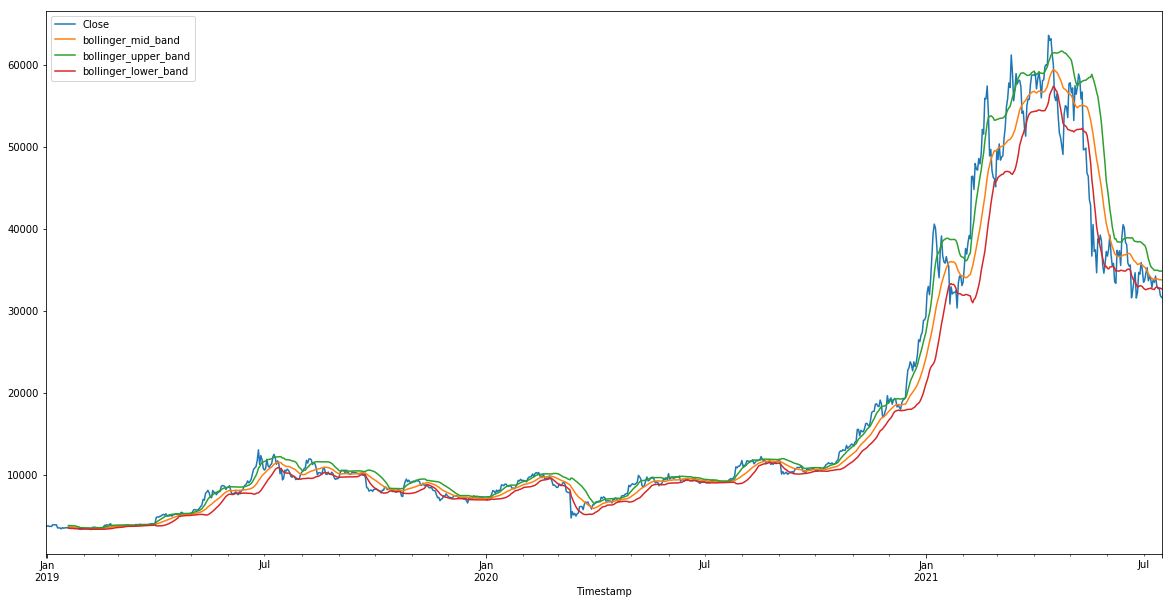

In [12]:
# Plot the Bollinger Bands for BTC/USD closing prices
btc_df[["Close","bollinger_mid_band","bollinger_upper_band","bollinger_lower_band"]].plot(figsize=(20,10))

In [13]:
# Set up RSI Indicator
btc_df['rsi'] = momentum.RSIIndicator(btc_df['Close'],window=14).rsi()

# Trading Signals/ Indicators

In [14]:
trading_signals_df = btc_df.copy()

In [15]:
# Set x variable list of features
x_var_list = ["crossover_signal", "vol_trend_signal", "bollinger_signal", "rsi"]

# Filter by x-variable list
trading_signals_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-12,-1.0,1.0,0.0,44.174976
2021-07-13,-1.0,1.0,1.0,43.076937
2021-07-14,-1.0,1.0,0.0,43.459703
2021-07-15,-1.0,1.0,1.0,40.411624
2021-07-16,-1.0,1.0,1.0,39.714441


In [16]:
# Shift DataFrame values by 1
trading_signals_df[x_var_list] = trading_signals_df[x_var_list].shift(1)
trading_signals_df[x_var_list].head()

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2018-12-31,NaN,NaN,NaN,NaN
2019-01-01,0.0,0.0,0.0,NaN
2019-01-02,1.0,0.0,0.0,NaN
2019-01-03,1.0,-1.0,0.0,NaN
2019-01-04,1.0,-1.0,0.0,NaN


In [17]:
# Drop NAs
trading_signals_df = trading_signals_df.dropna(subset=x_var_list)
trading_signals_df = trading_signals_df.dropna(subset=["target"])

# Replace positive/negative infinity values
trading_signals_df = trading_signals_df.replace([np.inf, -np.inf], np.nan)

# Display sample data
trading_signals_df.head()

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-14,3477.56,3671.87,3467.02,3626.09,35235.211215,0.042936,-0.087879,3671.572597,3737.896732,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,31.251957
2019-01-15,3626.08,3648.42,3516.62,3553.06,34137.997459,-0.020140,-0.101658,3646.501673,3719.425552,0.0,...,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,43.590937
2019-01-16,3553.06,3645.00,3543.51,3591.84,27480.179977,0.010915,-0.094490,3634.998545,3707.082513,0.0,...,0.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,39.825111
2019-01-17,3591.84,3634.70,3530.39,3616.21,29755.440838,0.006785,0.008458,3631.060953,3698.545416,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,42.657991
2019-01-18,3613.32,3620.00,3565.75,3594.87,22713.446755,-0.005901,-0.001788,3623.501024,3689.061406,0.0,...,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,44.428497


### Classification (Random Forest) Indicator

In [18]:
# Dependent variable where if hourly return is greater than 0, then 1, else, 0.
trading_signals_df["Positive Return"] = np.where(trading_signals_df["target"] > 0, 1.0, 0.0)

trading_signals_df.head(5)

,Open,High,Low,Close,Volume,hourly_return,target,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,rsi,Positive Return
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-14,3477.56,3671.87,3467.02,3626.09,35235.211215,0.042936,-0.087879,3671.572597,3737.896732,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,31.251957,0.0
2019-01-15,3626.08,3648.42,3516.62,3553.06,34137.997459,-0.020140,-0.101658,3646.501673,3719.425552,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,43.590937,0.0
2019-01-16,3553.06,3645.00,3543.51,3591.84,27480.179977,0.010915,-0.094490,3634.998545,3707.082513,0.0,...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,39.825111,0.0
2019-01-17,3591.84,3634.70,3530.39,3616.21,29755.440838,0.006785,0.008458,3631.060953,3698.545416,0.0,...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,42.657991,1.0
2019-01-18,3613.32,3620.00,3565.75,3594.87,22713.446755,-0.005901,-0.001788,3623.501024,3689.061406,0.0,...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,44.428497,0.0


In [19]:
# Dependent variable where if hourly return is greater than 4%, then 1, else, 0 and if less than -4%, -1.
trading_signals_df["Positive Return"] = 0 
trading_signals_df.loc[trading_signals_df["target"]>0.04,'Positive Return'] = 1
trading_signals_df.loc[trading_signals_df["target"]<-0.04,'Positive Return'] = -1

In [20]:
# Includes pos and neg returns
trading_signals_df["Positive Return"].value_counts()

 0    371
 1    346
-1    198
Name: Positive Return, dtype: int64

In [21]:
# Using first 80% of time for training and testing on last 20% of time

# Training start and end dates
training_start = trading_signals_df.index.min().strftime(format= "%Y-%m-%d")
training_end = training_end = trading_signals_df.index[int(len(trading_signals_df)*0.8)]

# Testing start and end dates
testing_start =  trading_signals_df.index[int(len(trading_signals_df)*0.8)+1]
testing_end = trading_signals_df.index.max().strftime(format= "%Y-%m-%d")

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2019-01-14
Training End: 2021-01-15 00:00:00
Testing Start: 2021-01-16 00:00:00
Testing End: 2021-07-16


In [22]:
# Construct the X_train and y_train datasets
X_train = trading_signals_df[x_var_list][training_start:training_end]
y_train = trading_signals_df["Positive Return"][training_start:training_end]

# Display sample data
display(X_train.tail())
display(y_train.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-01-11,1.0,-1.0,-1.0,76.451973
2021-01-12,1.0,-1.0,0.0,64.755624
2021-01-13,1.0,-1.0,0.0,59.892027
2021-01-14,1.0,-1.0,0.0,66.533442
2021-01-15,1.0,-1.0,-1.0,69.443489


Timestamp
2021-01-11    1
2021-01-12    0
2021-01-13    0
2021-01-14    0
2021-01-15   -1
Name: Positive Return, dtype: int64

In [23]:
# Construct the X test and y test datasets
X_test = trading_signals_df[x_var_list][testing_start:testing_end]
y_test = trading_signals_df["Positive Return"][testing_start:testing_end]

# Display sample data
display(X_test.tail())
display(y_test.tail())

,crossover_signal,vol_trend_signal,bollinger_signal,rsi
Timestamp,,,,
2021-07-12,-1.0,1.0,0.0,47.899607
2021-07-13,-1.0,1.0,0.0,44.174976
2021-07-14,-1.0,1.0,1.0,43.076937
2021-07-15,-1.0,1.0,0.0,43.459703
2021-07-16,-1.0,1.0,1.0,40.411624


Timestamp
2021-07-12    0
2021-07-13   -1
2021-07-14    0
2021-07-15    0
2021-07-16   -1
Name: Positive Return, dtype: int64

In [24]:
# SKLearn random forest using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=5,min_samples_split=15, random_state=55)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame
results = y_test.to_frame()
results["Predicted Value"] = predictions

# Display sample data
results['Predicted Value'].value_counts()

 0    108
 1     41
-1     33
Name: Predicted Value, dtype: int64

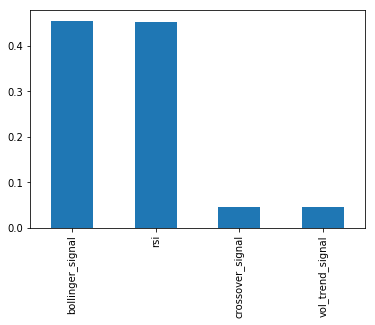

In [25]:
# Features that are most important
feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='bar')

In [26]:
# Save the pre-trained model
dump(model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [27]:
# Load the model and make the predictions from the X_test dataset
model = load("random_forest_model.joblib")
predictions = model.predict(X_test)

# Display sample predictions
predictions[:10]

array([ 0,  0,  0,  0,  0,  0, -1, -1, -1, -1], dtype=int64)

In [28]:
results["Predicted Value"].value_counts()

 0    108
 1     41
-1     33
Name: Predicted Value, dtype: int64

In [29]:
# Add predicted results to DataFrame
results["Predicted Value"] = predictions

# Display sampe data
results.head(10)

,Positive Return,Predicted Value
Timestamp,,
2021-01-16,-1,0
2021-01-17,-1,0
2021-01-18,0,0
2021-01-19,1,0
2021-01-20,-1,0
2021-01-21,-1,0
2021-01-22,-1,-1
2021-01-23,-1,-1
2021-01-24,-1,-1


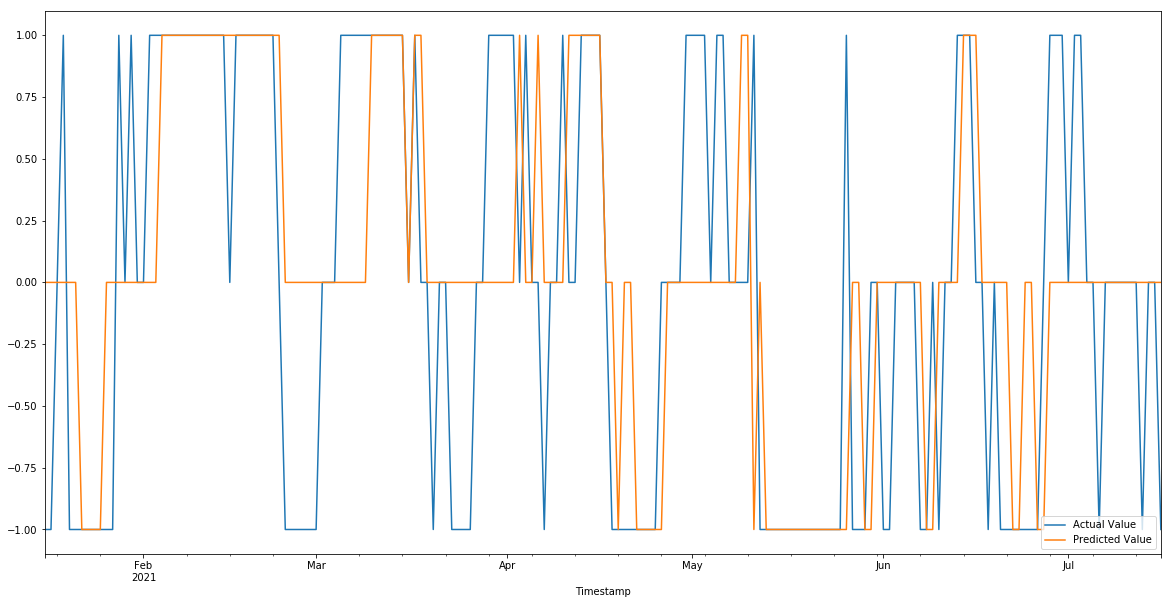

In [30]:
# Plot predicted results vs. actual results
results['Actual Value'] = y_test
results[["Actual Value", "Predicted Value"]].plot(figsize=(20,10))

In [31]:
# Replace predicted values 0 to -1 to account for shorting
results["Predicted Value"] = results["Predicted Value"].replace(0, -1)

# Display sample data
results

,Positive Return,Predicted Value,Actual Value
Timestamp,,,
2021-01-16,-1,-1,-1
2021-01-17,-1,-1,-1
2021-01-18,0,-1,0
2021-01-19,1,-1,1
2021-01-20,-1,-1,-1
...,...,...,...
2021-07-12,0,-1,0
2021-07-13,-1,-1,-1
2021-07-14,0,-1,0


### The Model In Action (Results)

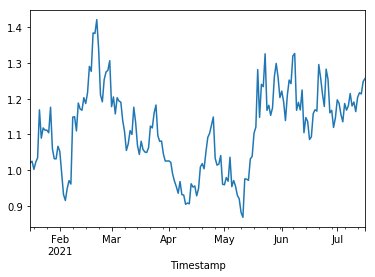

In [32]:
# Cumulative return of the model
results['Return'] = trading_signals_df['hourly_return'][testing_start:testing_end]
cumulative_return = (1 + (results["Return"] * results["Predicted Value"])).cumprod()

# Plotting cumulative returns
cumulative_return.plot()

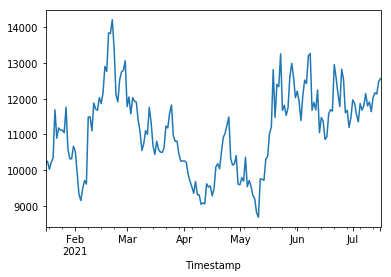

In [33]:
# Set initial capital allocation
initial_capital = 10000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * cumulative_return
cumulative_return_capital.plot()

### Return Groupings

In [34]:
group_df = btc_df.copy()

In [35]:
# Assess the confidence in each prediction in the model
results['probability'] = model.predict_proba(X_test)[:,1]

In [36]:
results

,Positive Return,Predicted Value,Actual Value,Return,probability
Timestamp,,,,,
2021-01-16,-1,-1,-1,-0.020337,0.677452
2021-01-17,-1,-1,-1,-0.004622,0.677410
2021-01-18,0,-1,0,0.022403,0.686465
2021-01-19,1,-1,1,-0.020195,0.728859
2021-01-20,-1,-1,-1,-0.011793,0.695230
...,...,...,...,...,...
2021-07-12,0,-1,0,-0.034221,0.708625
2021-07-13,-1,-1,-1,-0.010786,0.724591
2021-07-14,0,-1,0,0.002757,0.686712


In [39]:
# Looking at the results by a group (i.e. 5 in this case) and the count and mean return
results['probability_quantile'] = pd.qcut(results['probability'],5,duplicates='drop')
group_results = results.groupby('probability_quantile').agg(['count','mean'])[['Return']]
group_results

# Set up code for confidence levels when the return is negative vs when positive

Return          
                      count      mean
probability_quantile                 
(0.0255, 0.197]          37  0.002224
(0.197, 0.432]           36  0.008090
(0.432, 0.563]           36  0.003654
(0.563, 0.694]           36  0.001794
(0.694, 0.768]           37 -0.014054

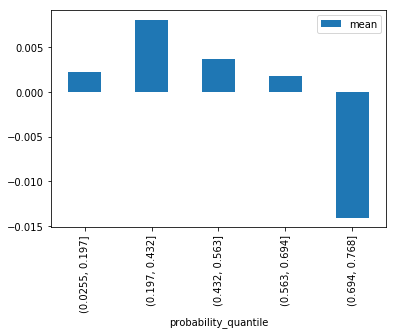

In [48]:
# Plot results - bar chart (mean)
plot_results = pd.DataFrame(group_results['Return']['mean'])
plot_results.plot.bar()